## Logistic回归模型

In [2]:
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#设定随机种子
torch.manual_seed(2017)

### 导入数据并可视化

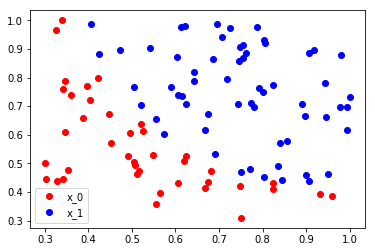

In [5]:
f=open('./data.txt','r')
data_list=[i.split('\n')[0].split(',') for i in f.readlines()]
data = [(float(i[0]), float(i[1]), float(i[2])) for i in data_list]
f.close()
# print(data)
# 标准化
x0_max=max([i[0] for i in data])
x1_max=max([i[1] for i in data])
data=[(i[0]/x0_max, i[1]/x1_max, i[2]) for i in data]
#从list中筛选部分参数的写法!
x0 = list(filter(lambda x:x[-1]==0.0, data)) #第一类点
x1 = list(filter(lambda x:x[-1]==1.0, data)) #第二类点

plot_x0 = [i[0] for i in x0]
plot_y0 = [i[1] for i in x0]
plot_x1 = [i[0] for i in x1]
plot_y1 = [i[1] for i in x1]

plt.plot(plot_x0, plot_y0, 'ro', label='x_0')
plt.plot(plot_x1, plot_y1, 'bo', label='x_1')
plt.legend(loc='best')


### 得到训练数据
接下来我们将数据转换成 NumPy 的类型，接着转换到 Tensor 为之后的训练做准备

In [8]:
np_data = np.array(data, dtype='float32') # 转换成 numpy array
x_data = torch.from_numpy(np_data[:, 0:2]) # 转换成 Tensor, 大小是 [100, 2]
y_data = torch.from_numpy(np_data[:, -1]).unsqueeze(1) # 转换成 Tensor，大小是 [100, 1]

x_data = Variable(x_data)
y_data = Variable(y_data)

### 定义logistic回归模型
在 PyTorch 当中，不需要我们自己写 Sigmoid 的函数，PyTorch 已经用底层的 C++ 语言为我们写好了一些常用的函数，不仅方便我们使用，同时速度上比我们自己实现的更快，稳定性更好

通过导入 `torch.nn.functional` 来使用，下面就是使用方法

In [9]:
import torch.nn.functional as F

# 定义 logistic 回归模型
w = Variable(torch.randn(2, 1), requires_grad=True) #因为输入是2维,所以w的shape是[2,1]
b = Variable(torch.zeros(1), requires_grad=True)

def logistic_regression(x):
    return F.sigmoid(torch.mm(x, w) + b)

### 训练之前的分类效果

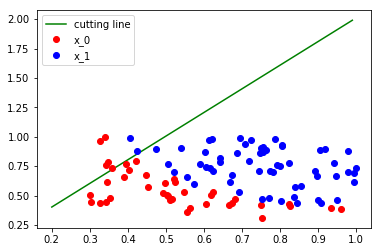

In [15]:
w0 = w[0].data[0]
w1 = w[1].data[0]
b0 = b.data[0]

plot_x = torch.Tensor(np.arange(0.2, 1, 0.01))
plot_y = (-w0 * plot_x - b0) / w1 #这个公式从何而来?,下边见详解

plt.plot(plot_x, plot_y, 'g', label='cutting line')#分割线

plt.plot(plot_x0, plot_y0, 'ro', label='x_0')
plt.plot(plot_x1, plot_y1, 'bo', label='x_1')
plt.legend(loc='best')

#### 扩展: `plot_y = (-w0 * plot_x - b0) / w1`从何而来?
输入有两个维度,即
$$
x=(x_0,x_1)
$$
对应分割线的公式是
$$
w_0*x_0+w_1*x_1+b_0=0
$$
上面的`plot_x`对应着$x_0$,`plot_y`对应$x_1$,所以从以上公式自然有:
$$
x_1=(-w_0*x_0-b_0)/w_1
$$

可以看到分类效果基本是混乱的，我们来计算一下 loss，公式如下

$$
loss = -(y * log(\hat{y}) + (1 - y) * log(1 - \hat{y}))
$$

### 定义损失函数

In [17]:
def binary_loss(y_pred,y_true):
    loss=y_true*y_pred.clamp(1e-12).log()+(1-y_true)*(1-y_pred).clamp(1e-12).log()
    return -loss
#log函数不能接受负值, 所以我们此处加上了tensor.clamp(1e-12),保证是个正数. tensor.clamp(min,max)是保证tensor的数值在区间之内

#### 扩展: `tensor.clamp(min,max)`, `tensor.clamp_(min,max)`

In [22]:
tensor=torch.randn(2,3)
print('原始tensor:\n{}'.format(tensor))
tensor2=tensor.clamp(-0.5,0.5)
tensor.clamp_(-0.5,0.5)
print('框定区间后:\n{}'.format(tensor))
print('框定区间后:\n{}'.format(tensor2))

原始tensor:
tensor([[-1.3343, -0.1449,  0.5423],
        [ 2.0257,  0.6302,  1.2472]])
框定区间后:
tensor([[-0.5000, -0.1449,  0.5000],
        [ 0.5000,  0.5000,  0.5000]])
框定区间后:
tensor([[-0.5000, -0.1449,  0.5000],
        [ 0.5000,  0.5000,  0.5000]])
